In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import tensorflow as tf
tfd = tf.contrib.distributions
tfb = tfd.bijectors
from tensorflow.keras import layers, models

class PiecewiseLinear(tfb.Bijector):
    """
    Piecewise Linear: based on 1808.03856
    """
    def __init__(self, D, d, nbins, layer_id=0, validate_args=False, name="PiecewiseLinear"):
        """
        Args:
            D: number of dimensions
            d: First d units are pass-thru units.
        """
        super(PiecewiseLinear, self).__init__(
            forward_min_event_ndims=1, validate_args=validate_args, name=name
        )
        self.D, self.d = D, d
        self.id = layer_id
        self.nbins = nbins
        self.width = 1.0/self.nbins
        self.range = tf.cast(tf.range(self.d),dtype=tf.int32)
        self.QMat = self.buildQ(self.d, self.nbins)
        self.trainable_variables = self.QMat.trainable_variables
        
    def buildQ(self, d, nbins):
        inval = layers.Input(shape=(d,))
        h1 = layers.Dense(64,use_bias=True,activation='relu',kernel_initializer='glorot_uniform')(inval)
        s1 = layers.Dense(d*nbins,use_bias=False,activation='relu',kernel_initializer='glorot_uniform')(h1)
        r1 = layers.Reshape((d,nbins))(s1)
        b1 = layers.BatchNormalization(axis=-1)(r1)
        r2 = layers.Flatten()(b1)
        h2 = layers.Dense(128,use_bias=True,activation='relu',kernel_initializer='glorot_uniform')(r2)
        s2 = layers.Dense(d*nbins,use_bias=False,activation='relu',kernel_initializer='glorot_uniform')(h2)
        r3 = layers.Reshape((d,nbins))(s2)
        b2 = layers.BatchNormalization(axis=-1)(r3)
        r4 = layers.Flatten()(b2)
        h3 = layers.Dense(64,use_bias=True,activation='relu',kernel_initializer='glorot_uniform')(r4)
        s3 = layers.Dense(d*nbins,use_bias=False,activation='relu',kernel_initializer='glorot_uniform')(h3)
        out = layers.Reshape((d,nbins))(s3)
        model = models.Model(inval,out)
        model.summary()
        return model
    
    def bin(self, x):
        xd, xD = x[:, :self.d], x[:, self.d:]
        Q = tf.nn.softmax(self.QMat(xd),axis=2)
        X=tf.transpose(xD)
        m=tf.shape(X)[1]
        Qcum=tf.reshape(tf.cumsum(Q,axis=1),[self.d,m,self.nbins])
        mask=(tf.reshape(X,(self.d,m,1))-Qcum>1e-08)
        Qtrun=tf.cast(mask,tf.float32)*Qcum
        b=tf.cast(tf.reshape(tf.argmax(Qtrun,axis=-1),(self.d,m)),tf.int32)
        b=b+tf.reshape(tf.cast(tf.reduce_max(Qtrun,axis=-1)>0,tf.int32),(self.d,m))*tf.cast(tf.ones((self.d,m)),tf.int32)+1
        return tf.transpose(b)
        
    def Q(self, xd):
        QMat = tf.nn.softmax(self.QMat(xd),axis=2)
        QMat = tf.pad(QMat,[[0,0],[0,0],[1,0]])
        return QMat
        
    def pdf(self,x):
        xd, xD = x[:, :self.d], x[:, self.d:]
        Q = self.Q(xd)
        ibins = tf.cast(tf.floor(xD*self.nbins)+1,dtype=tf.int32)
        batch_range = tf.range(tf.shape(xD)[0])
        grid = tf.transpose(tf.meshgrid(batch_range,self.range))
        bins = tf.concat([grid,tf.gather_nd(ibins,grid)[...,tf.newaxis]],axis=2)
        return tf.concat([xd, tf.gather_nd(Q,bins)/self.width], axis=1)
        
    def _forward(self, x):
        "Calculate forward coupling layer"
        xd, xD = x[:, :self.d], x[:, self.d:]
        Q = self.Q(xd)
        ibins = tf.cast(tf.floor(xD*self.nbins),dtype=tf.int32)
        ibinsp1 = ibins+1
        batch_range = tf.range(tf.shape(xD)[0])
        grid = tf.transpose(tf.meshgrid(batch_range,self.range))
        bins = tf.concat([grid,tf.gather_nd(ibinsp1,grid)[...,tf.newaxis]],axis=2)
        binsSum = tf.concat([grid,tf.gather_nd(ibins,grid)[...,tf.newaxis]],axis=2)
        yD = (xD*self.nbins-tf.cast(ibins,dtype=tf.float32))*tf.gather_nd(Q,bins)+tf.gather_nd(tf.cumsum(Q,axis=2),binsSum)
        return tf.concat([xd, yD], axis=1)
        
    def _inverse(self, y):
        "Calculate inverse coupling layer"
        yd, yD = y[:, :self.d], y[:, self.d:]
        Q = self.Q(yd)
        ibins = tf.cast(tf.searchsorted(tf.cumsum(Q,axis=2),yD[...,tf.newaxis],side='right'),dtype=tf.int32)
        ibins = tf.reshape(ibins,[tf.shape(yD)[0],self.d])
        ibins = ibins-1
        ibinsp1 = ibins+1
        batch_range = tf.range(tf.shape(yD)[0])
        grid = tf.transpose(tf.meshgrid(batch_range,self.range))
        bins = tf.concat([grid,tf.gather_nd(ibinsp1,grid)[...,tf.newaxis]],axis=2)
        binsSum = tf.concat([grid,tf.gather_nd(ibins,grid)[...,tf.newaxis]],axis=2)
        xD = ((yD-tf.gather_nd(tf.cumsum(Q,axis=2),binsSum))*tf.reciprocal(tf.gather_nd(Q,bins))\
              +tf.cast(ibins,dtype=tf.float32))*self.width
        xD = tf.where(tf.is_nan(xD), tf.ones_like(xD), xD)
        return tf.concat([yd, xD], axis=1)
    
    def _forward_log_det_jacobian(self, x):
        "Calculate log determinant of Coupling Layer"
        return tf.reduce_sum(tf.log(self.pdf(x)[:,self.d:]),axis=-1)
    
    def _inverse_log_det_jacobian(self, y):
        "Calculate log determinant of Coupling Layer"
        yd, yD = y[:, :self.d], y[:, self.d:]
        Q = self.Q(yd)
        ibins = tf.cast(tf.searchsorted(tf.cumsum(Q,axis=2),yD[...,tf.newaxis],side='right'),dtype=tf.int32)
        ibins = tf.reshape(ibins,[tf.shape(yD)[0],self.d])
        ibins = ibins-1
        ibinsp1 = ibins+1
        batch_range = tf.range(tf.shape(yD)[0])
        grid = tf.transpose(tf.meshgrid(batch_range,self.range))
        bins = tf.concat([grid,tf.gather_nd(ibinsp1,grid)[...,tf.newaxis]],axis=2)
        return -tf.reduce_sum(tf.log(tf.gather_nd(Q,bins)/self.width),axis=-1)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Settings

In [2]:
NP_DTYPE = np.float32

## Testing

In [3]:
tf.enable_eager_execution()

In [3]:
test = PiecewiseLinear(6,3,5)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                960       
_________________________________________________________________
reshape (Reshape)            (None, 3, 5)              0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 3, 5)              20        
_________________________________________________________________
flatten (Flatten)            (None, 15)                0         
_________________________________________________________________
dens

In [13]:
val = np.array(np.random.rand(10,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))
test.bin(val)

True


<tf.Tensor: id=1886, shape=(10, 3), dtype=int32, numpy=
array([[3, 4, 1],
       [3, 4, 1],
       [1, 3, 3],
       [3, 3, 3],
       [1, 1, 3],
       [1, 1, 1],
       [3, 3, 1],
       [1, 3, 3],
       [3, 3, 1],
       [4, 1, 1]], dtype=int32)>

In [6]:
np.allclose(test.forward_log_det_jacobian(val,event_ndims=1),-test.inverse_log_det_jacobian(forward,event_ndims=1))

True

In [11]:
test = PiecewiseQuadratic(6,3,5)

In [6]:
val = np.array(np.random.rand(1000,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))
print(((val-inverse.numpy())/val)[np.logical_not(np.isclose(val,inverse.numpy()))])

True
[]


## Training

In [14]:
tf.disable_eager_execution()

In [4]:
sess = tf.InteractiveSession()

In [44]:
bijectors = []

for i in range(4):
    bijectors.append(PiecewiseLinear(2,1,10,layer_id=i))
    bijectors.append(tfb.Permute(permutation=[1,0]))

# Discard the last Permute layer
test_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
test_bijector.forward_min_event_ndims

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_31 (Dense)             (None, 10)                640       
_________________________________________________________________
reshape_15 (Reshape)         (None, 1, 10)             0         
_________________________________________________________________
batch_normalization_v1_10 (B (None, 1, 10)             40        
_________________________________________________________________
flatten_10 (Flatten)         (None, 10)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               1408      
__________

1

In [114]:
base_dist = tfd.Uniform(low=[0.0,0.0],high=[1.0,1.0])
base_dist = tfd.Independent(distribution=base_dist,
                           reinterpreted_batch_ndims=1,
                           )
#base_dist = tfd.MultivariateNormalDiag(loc=[0., 0.])
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=test_bijector
)

base_dist

<tfp.distributions.Independent 'IndependentUniform_3/' batch_shape=() event_shape=(2,) dtype=float32>

In [46]:
x = base_dist.sample(1000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

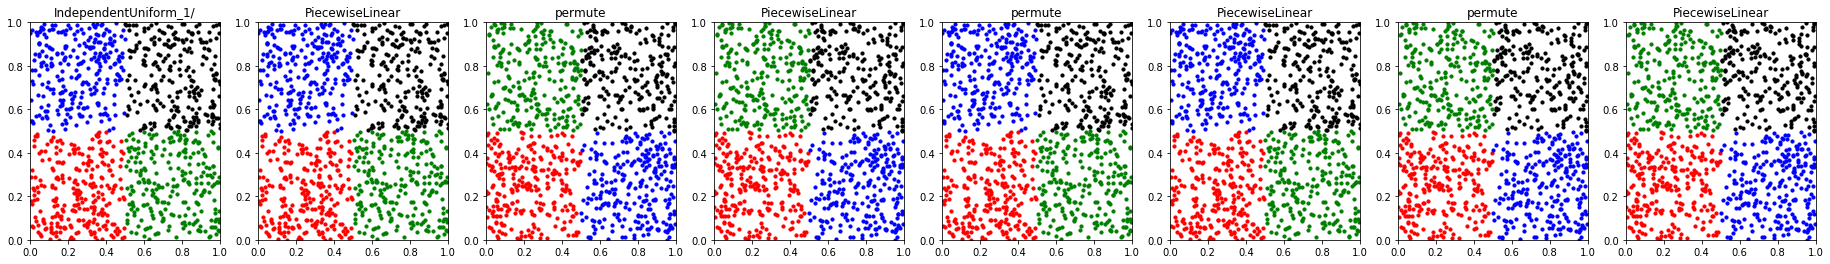

In [47]:
sess.run(tf.global_variables_initializer())
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

In [103]:
for bijector in reversed(dist.bijector.bijectors):
    try:
        print(sess.run(bijector.trainable_variables))
    except AttributeError:
        pass

[array([[ 0.19794255,  0.28883582,  0.26240903,  0.2921518 ,  0.03584373,
        -0.07188986, -0.1063484 ,  0.07857692,  0.05085784,  0.11572301,
        -0.17578454, -0.04611656,  0.10716504,  0.02648446,  0.05422217,
         0.20974189,  0.24693292,  0.04294544, -0.2969251 , -0.06820558,
         0.1897623 , -0.2530628 , -0.06286816,  0.18101534, -0.14415582,
        -0.09963466,  0.15490681, -0.23748183, -0.03033775,  0.21230012,
         0.05141845, -0.17319441,  0.10213706, -0.12210643, -0.18157093,
        -0.29689664, -0.1607439 ,  0.03761193, -0.05401914, -0.2011169 ,
         0.06485003, -0.16582665, -0.00156066,  0.13743296,  0.15700865,
         0.12440327, -0.22046492, -0.15867063,  0.25977665,  0.27364957,
         0.06027904, -0.27712807,  0.08620417, -0.00555083,  0.2659648 ,
        -0.04221267,  0.24870056,  0.17007211,  0.03978828,  0.23085481,
        -0.03692549,  0.01295191, -0.2870091 ,  0.169325  ]],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 

[array([[ 0.28264183, -0.15522228,  0.19351646,  0.08655187, -0.23979212,
         0.08821589,  0.12568262,  0.11546716,  0.09042838,  0.0053851 ,
        -0.08502018, -0.23105827,  0.06505358, -0.13040501,  0.16782662,
        -0.15673925, -0.01936668, -0.02920288, -0.10374451,  0.28534812,
        -0.2166745 , -0.03964043,  0.2784422 ,  0.2252047 , -0.13144687,
         0.2610914 , -0.14246805, -0.08101226,  0.00926822, -0.08436492,
         0.03127661,  0.24916542,  0.0201419 ,  0.06741226,  0.14561042,
         0.16943133,  0.11322454,  0.00817665, -0.03918207, -0.05640143,
         0.1043227 , -0.25332996, -0.06503488, -0.21485272,  0.28254157,
         0.18522972,  0.10065523,  0.10245702, -0.01530892,  0.22506088,
         0.1540972 , -0.13796364,  0.24037862,  0.03681216,  0.25133878,
         0.20679444,  0.22413892, -0.01658267, -0.20558473,  0.16657588,
         0.13508421,  0.28012866,  0.12769103, -0.14283994]],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 

In [117]:
def step(x,x0,k=50):
    return (1/2+1/2*tf.tanh(k*(x0-x)))

def dsigmaTrain(x):
    #return tf.where(tf.logical_and(x[:,0] < tf.ones_like(x[:,0])*0.9,x[:,1] < tf.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), tf.zeros_like(x[:,0]))
    return (x[:,0]**2+x[:,1]**2)/((1-x[:,0])*(1-x[:,1]))*step(x[:,0],0.9)*step(x[:,1],0.9)

def dsigmaTrue(x):
    return tf.where(tf.logical_and(x[:,0] < tf.ones_like(x[:,0])*0.9,x[:,1] < tf.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), tf.zeros_like(x[:,0]))

def dsigmaTest(x):
    return 10**7*(1+x[:,0]**2)/((90**2-(90*2*(1-x[:,1]))**2)**2+2.5**2*90**2)

def normal(x):
    return 0.124* tf.exp((-0.5*(x[:,0]* (1.22 *x[:,0] -  0.36* x[:,1]) + (-0.36*x[:,0] + 0.61*x[:,1])* x[:,1])))


In [123]:
x = dist.sample(5000)
X = dist.log_prob(x)
q = tf.exp(X)
dsig = dsigmaTest(x)

xPts, logqPts, qPts, dsigPts = sess.run([x,X,q,dsig])

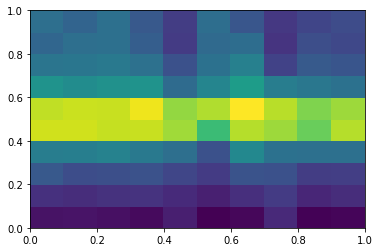

In [124]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=dsigPts,norm=mpl.colors.LogNorm())
plt.show()

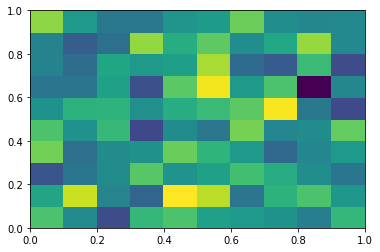

In [50]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=qPts,norm=mpl.colors.LogNorm())
plt.show()

In [51]:
loss = -sess.run(tf.reduce_mean(dsig*X))
print(loss)

-0.009898209


In [156]:
def loss_fn(lamda):
    x = dist.sample(1000)
    logq = dist.log_prob(x)
    p = dsigmaTest(x)
    q = tf.exp(logq)
    return tf.reduce_mean(-p*tf.log(p)+ p*logq + lamda*(p-q)*(p-q)), x

In [415]:
def loss_fn2():
    x = dist.sample(10000)
    q = tf.exp(dist.log_prob(x))
    p = dsigmaTrain(x)
    return tf.reduce_mean(p*p/q)

In [416]:
def loss_fn3():
    x = dist.sample(10000)
    logq = dist.log_prob(x)
    q = tf.exp(logq)
    p = dsigmaTrain(x)
    return -tf.reduce_mean(p*logq)+tf.reduce_mean(p*p/q)

In [417]:
def grad():
    with tf.GradientTape() as tape:
        loss_value = loss_fn()
    return loss_value, tape.gradient(loss_value, bijector.trainable_variables)

In [157]:
loss = loss_fn(0.005)
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-08,
    use_locking=False,
    name='Adam')
grads = optimizer.compute_gradients(loss[0])
opt_op = optimizer.apply_gradients(grads)
sess.run(tf.global_variables_initializer())

0 -16.651968


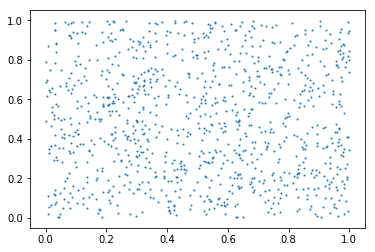

500 -20.189487


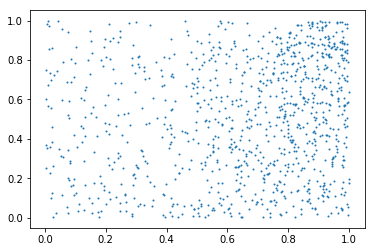

1000 -55.642902


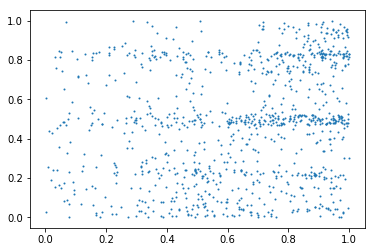

1500 -68.23342


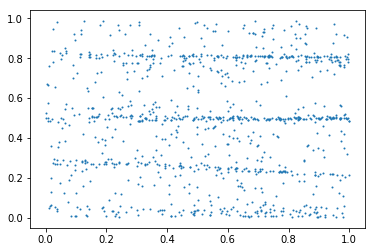

2000 -78.8314


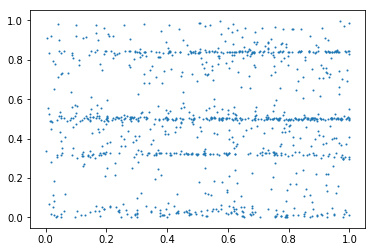

2500 -84.45107


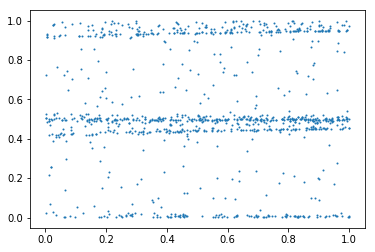

3000 -122.8832


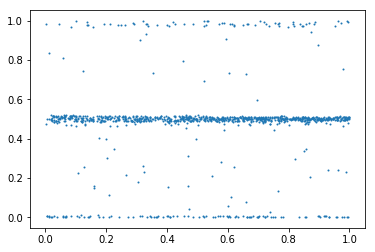

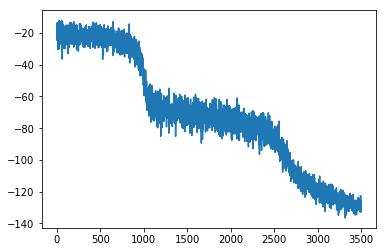

In [158]:
np_losses = []
global_step = []
sample=[]
for epoch in range(3500):
    _, np_loss = sess.run([opt_op, loss])
    global_step.append(epoch)
    np_losses.append(np_loss[0])
    sample.append(np_loss[1])
    if epoch % 500 == 0:
        print(epoch, np_loss[0])
        xPts = np_loss[1]
        plt.scatter(xPts[:,0],xPts[:,1],s=1)
        plt.show()
        
start = 0
plt.plot(np_losses[start:])

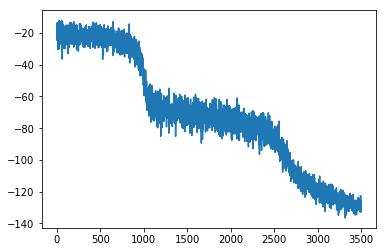

In [159]:
plt.plot(np_losses[start:])

In [89]:
for bijector in reversed(dist.bijector.bijectors):
    try:
        print(sess.run(bijector.trainable_variables))
    except AttributeError:
        pass

[array([[ 0.01104092,  0.00118008,  0.14998233,  0.2521984 ,  0.2099407 ,
        -0.16240996, -0.28304803,  0.1462459 , -0.24130121,  0.19695902,
         0.17949544, -0.10273597, -0.0819044 ,  0.24724089, -0.18000992,
        -0.2267514 , -0.1739085 ,  0.11382676, -0.00064418,  0.18014582,
         0.05546863, -0.18376425,  0.22265132, -0.2234312 ,  0.16505384,
         0.27177697, -0.03189442,  0.17716543,  0.21047384, -0.2041386 ,
         0.18157586, -0.22080804,  0.21960242, -0.11923265, -0.01655868,
         0.01669163,  0.06835884, -0.23797193,  0.02424639,  0.1220014 ,
         0.07435351,  0.09163343, -0.14475386,  0.27760765, -0.21921393,
         0.12450765,  0.2546432 , -0.28073904, -0.06649093,  0.26738888,
         0.21753591,  0.10099375, -0.06355014, -0.29564282,  0.1852737 ,
         0.18160464, -0.21027747, -0.289589  ,  0.2667975 ,  0.15409876,
        -0.21374807,  0.2378587 ,  0.03396422, -0.05403739]],
      dtype=float32), array([-0.00808853, -0.00117959,  0.002

In [56]:
def bin_b(x,Q): #X=(m,d) Q=(d,nbins) K bins, m sampling points
    X=tf.transpose(x)
    (dim,K)=tf.shape(Q)
    m=tf.shape(X)[1]
    Qcum=tf.reshape(tf.cumsum(Q,axis=1),(dim,1,K))
    mask=(tf.reshape(X,(dim,m,1))-Qcum>ep)
    Qtrun=mask*Qcum
    b=tf.reshape(tf.argmax(Qtrun,axis=-1),(dim,m))
    b=b+tf.reshape(tf.reduce_max(Qtrun,axis=-1)>0,(dim,m))*tf.ones((dim,m))
    return tf.transpose(b) #return b=(dim,m)

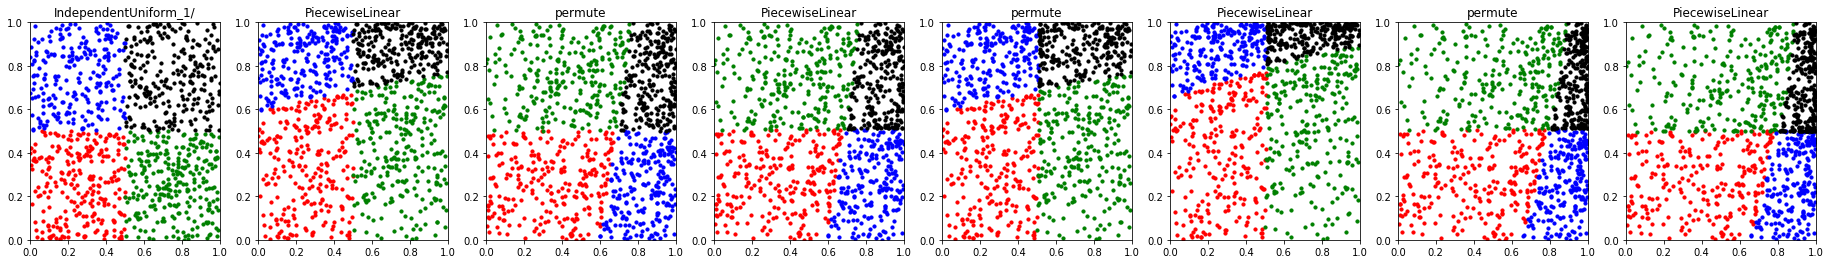

In [560]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

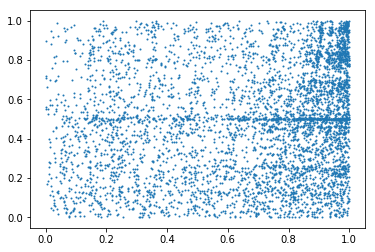

In [561]:
nsamples = 5000
x = dist.sample(nsamples)
X = dist.log_prob(x)
q = tf.exp(X)
dsig = dsigmaTest(x)

xPts, logqPts, qPts, dsigPts = sess.run([x,X,q,dsig])

plt.scatter(xPts[:,0],xPts[:,1],s=1)
plt.show()

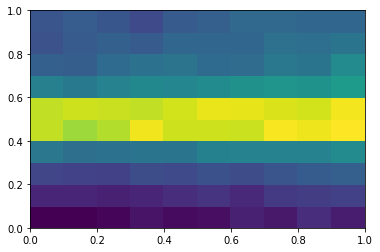

In [544]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=dsigPts/qPts,norm=mpl.colors.LogNorm())
plt.show()

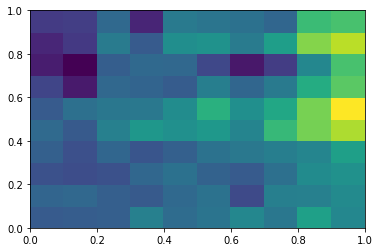

In [545]:
plt.hist2d(xPts[:,0],xPts[:,1],weights=qPts,norm=mpl.colors.LogNorm())
plt.show()

In [547]:
def dsigma_np(x1,x2):
    return (x1**2 + x2**2)/((1-x1)*(1-x2))

def dsigmaTest_np(x1,x2):
    return (1+x1**2)/((90**2-(90*2*(1-x2))**2)**2+2.5**2*90**2)

In [548]:
import scipy.integrate as integrate

print(integrate.dblquad(dsigmaTest_np,0.0,1,0.0,1))

(5.738315882225917e-07, 4.50462926257536e-10)


In [555]:
mean, var = sess.run(tf.nn.moments(dsig/q,axes=[0]))
print('xsec = %e, var = %e' % (mean,var/np.sqrt(nsamples)))

xsec = 5.611313e+00, var = 3.943293e+00


In [462]:
x1 = tf.linspace(0.0,1,100)
x2 = tf.linspace(0.0,1,100)
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=0)),(10000,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])

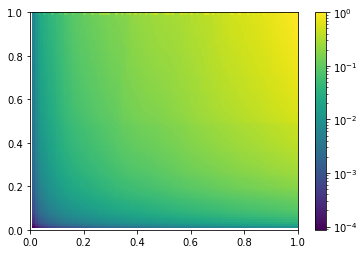

In [463]:
h = plt.hist2d(grid[:,0],grid[:,1],weights=cdf,norm=mpl.colors.LogNorm(),bins=100)
plt.colorbar(h[3])
plt.show()

In [464]:
x = tf.constant([0.8,0.2],shape=(1,2))
Y = dist.cdf(x)
sess.run([x,Y])

[array([[0.8, 0.2]], dtype=float32), array([0.1373798], dtype=float32)]

In [465]:
x = tf.constant([1.0,1.0],shape=(1,2))
Y = dist.cdf(x)
sess.run([x,Y])

[array([[1., 1.]], dtype=float32), array([1.], dtype=float32)]

In [24]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.1])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

NotImplementedError: cdf is not implemented: Independent

In [90]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.3])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

NotImplementedError: cdf is not implemented: Independent

In [92]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.5])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

NotImplementedError: cdf is not implemented: Independent

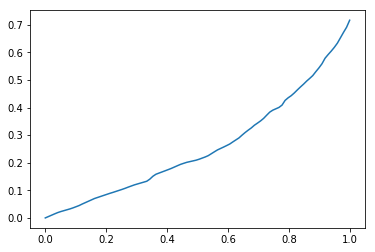

In [469]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.7])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

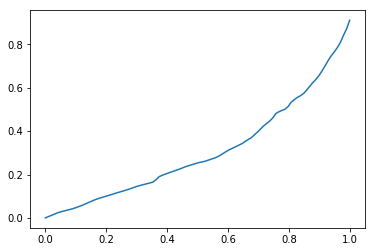

In [470]:
x1 = tf.linspace(0.0,1.0,100)
x2 = tf.constant([0.9])
X1,X2 = tf.meshgrid(x1,x2)
x = tf.reshape(tf.transpose(tf.stack([X1,X2],axis=1)),(100,2))
Y = dist.cdf(x)

grid, cdf = sess.run([x,Y])
plt.plot(grid[:,0],cdf)
plt.show()

In [49]:
sess.run(dist.distribution)

TypeError: Fetch argument <tfp.distributions.Independent 'IndependentUniform_1/' batch_shape=() event_shape=(2,) dtype=float32> has invalid type <class 'tensorflow.contrib.distributions.python.ops.independent.Independent'>, must be a string or Tensor. (Can not convert a Independent into a Tensor or Operation.)